# Tune_lgb
* 제출결과 : 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
import lightgbm as lgb

In [14]:
path = "./data/" 
train_df = pd.read_csv(path+'train.csv',index_col=0)
test_df = pd.read_csv(path+'test.csv',index_col=0)
sample_submission_df = pd.read_csv(path+'sample_submission.csv',index_col=0)
pd.options.display.max_columns = 30

## 전처리
 - 이상치 확인 및 처리

In [15]:
train_df.describe()

,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000
mean,360.830152,-6.750146e+00,18.675373,18.401235,18.043495,17.663526,1.084986e+01,19.072693,19.134483,18.183331,18.000882,21.837903,18.454136,18.481525,17.686617,17.699207,20.110991,18.544375,18.181544,17.692395,17.189281
std,225.305890,1.187678e+04,155.423024,127.128078,116.622194,123.735298,4.172116e+03,749.256162,90.049058,122.378972,145.862346,789.472333,154.376277,97.240448,145.730872,142.691880,122.299062,161.728183,133.984475,131.183416,133.685138
min,1.000000,-5.310802e+06,-40022.466071,-27184.795793,-26566.310827,-24878.828280,-1.864766e+06,-215882.917191,-21802.656144,-20208.516262,-26505.602101,-24463.431833,-25958.752324,-23948.588523,-40438.184078,-30070.729379,-26236.578659,-36902.402336,-36439.638493,-38969.416822,-26050.710196
25%,174.000000,1.965259e+01,18.701180,18.048572,17.747663,17.425523,1.994040e+01,18.902851,18.259352,17.903615,17.606148,19.247795,18.113933,17.479794,17.050294,16.804705,19.266214,18.076120,17.423425,16.977671,16.705774
50%,349.000000,2.087136e+01,19.904235,19.454492,19.043895,18.611799,2.104910e+01,20.069038,19.631419,19.188763,18.710967,20.366848,19.586559,19.182789,18.693370,18.174592,20.406840,19.547674,19.143156,18.641756,18.100997
75%,526.000000,2.216043e+01,21.150297,20.515936,20.073528,19.883760,2.233754e+01,21.385830,20.773911,20.331419,20.133179,21.797480,21.004397,20.457491,20.019112,19.807652,21.992898,20.962386,20.408140,19.968846,19.819554
max,1000.000000,1.877392e+04,3538.984910,3048.110913,4835.218639,9823.740407,4.870154e+03,248077.513380,12084.735440,8059.638535,18358.921741,298771.019041,12139.815877,7003.136546,9772.190537,17403.789263,14488.251976,10582.058590,12237.951703,4062.499371,7420.534172


In [16]:
def del_outlier(data, min=0, max=60):
    up_idx_t=()
    dw_idx_t=()
    train_light = data.iloc[:,2:]
    for i in range(len(train_light.columns)):
        col = train_light.columns[i]
        up_idx_t+=tuple(data[data[col]>max].index)
        dw_idx_t+=tuple(data[data[col]<min].index)
    del_idx = set(up_idx_t+dw_idx_t)
    
    return data[~data.index.isin(del_idx)]

In [17]:
train_df = del_outlier(train_df, min=-60, max=60)

In [18]:
train_df.describe()

,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,199805.000000,199805.000000,199805.000000,199805.000000,199805.000000,199805.000000,199805.000000,199805.000000,199805.000000,199805.000000,199805.000000,199805.000000,199805.000000,199805.000000,199805.000000,199805.000000,199805.000000,199805.000000,199805.000000,199805.000000,199805.000000
mean,360.874257,20.984096,19.860971,19.286994,18.872327,18.612319,21.171538,20.089746,19.505260,19.087316,18.828446,20.710347,19.600430,19.005845,18.605146,18.391528,20.731087,19.530585,18.939735,18.520452,18.276576
std,225.326886,2.084378,1.868696,1.721250,1.628469,1.684458,1.982522,1.842191,1.706138,1.626217,1.676483,2.441525,2.098483,1.971022,1.906945,2.056474,2.187267,1.959114,1.859963,1.796639,1.864622
min,1.000000,-12.978725,-19.537079,-43.795556,-6.406284,-6.793444,-55.669722,-8.294703,-11.531777,10.646672,8.049850,-50.847000,-52.501232,-56.256807,-34.494076,-45.646493,3.444448,12.498143,10.286917,11.337467,10.977328
25%,174.000000,19.652802,18.701527,18.048615,17.747666,17.425886,19.941482,18.903532,18.259827,17.904548,17.607016,19.248446,18.114513,17.480249,17.051207,16.805175,19.265847,18.075890,17.423282,16.977685,16.705562
50%,349.000000,20.870785,19.903867,19.454103,19.043575,18.611026,21.049142,20.069213,19.632080,19.189421,18.711351,20.366762,19.586264,19.182726,18.693855,18.173881,20.405706,19.546802,19.142725,18.641701,18.100568
75%,526.000000,22.158644,21.148771,20.515044,20.072993,19.883188,22.336839,21.385460,20.773880,20.331692,20.133244,21.795629,21.002840,20.456383,20.018679,19.806769,21.990515,20.960706,20.407299,19.968434,19.819179
max,1000.000000,53.410871,54.250456,54.501228,49.883443,42.136572,54.055822,37.745406,32.574603,42.002047,36.498179,58.298437,58.042137,55.633809,59.835880,57.578250,49.487277,59.987842,33.666494,45.783550,48.276514


In [19]:
train_df.columns

Index(['type', 'fiberID', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
       'psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i',
       'fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i',
       'petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
       'modelMag_z'],
      dtype='object')

## DATA Setting

In [20]:
column_number = {}
number_columns = {}
for i, column in enumerate(sample_submission_df.columns):
    column_number[column] = i
    number_columns[i] = column
    
    
def to_number(x, dic):
    return dic[x]

train_df['type_num'] = train_df['type'].apply(lambda x: to_number(x, column_number))


In [21]:
def add_minus_feature_all(data,test = False):
    from itertools import combinations
    n = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
        for combi in list(combinations(selected,2)):
            name_1st = str.split(combi[0],'_')[1]
            name_2nd = str.split(combi[1],'_')[1]
            data[mag+"_"+name_1st+"-"+name_2nd] = data[combi[0]]-data[combi[1]]
        n=count
    return data

In [22]:
def add_minus_feature(data,test = False):
    '''
    근접변수에 대해서만 컬럼생성 ex) 'fiberMag_u-g', 'fiberMag_g-r', 'fiberMag_r-i', 'fiberMag_i-z'
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 38개로 증가 
    '''
    from itertools import combinations
    n = 0
    m = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
#         data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for i in range(0,len(selected)):        
            if i>0: 
                name_1st = str.split(m,'_')[1]
                name_2nd = str.split(selected[i],'_')[1]
                data[mag+"_"+name_1st+"-"+name_2nd] = data[m]-data[selected[i]]
            m = selected[i]    
        n=count
    return data

In [23]:
train_df = add_minus_feature(train_df)
test_df = add_minus_feature(test_df,True)

In [24]:
# train_df.drop(columns=['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
#        'psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i',
#        'fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i',
#        'petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
#        'modelMag_z'], inplace=True)

# test_df.drop(columns=['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
#        'psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i',
#        'fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i',
#        'petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
#        'modelMag_z'], inplace=True)

In [25]:
train_X = train_df.drop(columns=['type', 'type_num', 'fiberID'], axis=1)
train_y = train_df['type_num']
test_X = test_df.drop(columns=['fiberID'], axis=1)

In [26]:
train_X.head()

,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,...,psfMag_g-r,psfMag_r-i,psfMag_i-z,fiberMag_u-g,fiberMag_g-r,fiberMag_r-i,fiberMag_i-z,petroMag_u-g,petroMag_g-r,petroMag_r-i,petroMag_i-z,modelMag_u-g,modelMag_g-r,modelMag_r-i,modelMag_i-z
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,23.198224,21.431953,21.314148,21.176553,21.171444,22.581309,21.644453,21.657571,21.387653,21.572827,22.504317,21.431636,21.478312,21.145409,20.422446,...,0.117805,0.137595,0.005109,0.936856,-0.013118,0.269918,-0.185174,1.072682,-0.046676,0.332902,0.722964,1.283708,0.101347,0.343582,-0.126735
1,21.431355,20.708104,20.678850,20.703420,20.473229,21.868797,21.029773,20.967054,20.937731,21.063646,21.360701,20.778968,20.889705,20.639812,20.646660,...,0.029254,-0.024570,0.230191,0.839024,0.062718,0.029324,-0.125915,0.581734,-0.110737,0.249893,-0.006847,0.734428,0.004602,0.060537,0.181074
2,17.851451,16.727898,16.679677,16.694640,16.641788,18.171890,17.033098,16.999682,17.095999,17.076449,17.867253,16.738784,16.688874,16.744210,16.808006,...,0.048221,-0.014963,0.052852,1.138792,0.033416,-0.096317,0.019550,1.128468,0.049910,-0.055336,-0.063796,1.120628,0.056186,-0.018929,-0.028751
3,20.789900,20.040371,19.926909,19.843840,19.463270,21.039030,20.317165,20.217898,20.073852,19.794505,20.433907,19.993727,19.985531,19.750917,19.455117,...,0.113462,0.083069,0.380569,0.721865,0.099267,0.144046,0.279347,0.440180,0.008197,0.234614,0.295800,0.769012,0.111901,0.131685,0.205258
4,26.454969,23.058767,21.471406,19.504961,18.389096,25.700632,23.629122,21.742750,19.861718,18.810375,25.859229,22.426929,21.673551,19.610012,18.376141,...,1.587361,1.966445,1.115864,2.071510,1.886372,1.881032,1.051343,3.432300,0.753377,2.063539,1.233871,1.729059,1.672651,1.988012,1.111675


In [27]:
train_X.columns

Index(['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z',
       'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i', 'fiberMag_z',
       'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z',
       'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z',
       'psfMag_u-g', 'psfMag_g-r', 'psfMag_r-i', 'psfMag_i-z', 'fiberMag_u-g',
       'fiberMag_g-r', 'fiberMag_r-i', 'fiberMag_i-z', 'petroMag_u-g',
       'petroMag_g-r', 'petroMag_r-i', 'petroMag_i-z', 'modelMag_u-g',
       'modelMag_g-r', 'modelMag_r-i', 'modelMag_i-z'],
      dtype='object')

In [28]:
# ## u-g, g-r, r-i, i-z 만 남기는게 좋지 않을까????
# train_X.drop(['psfMag_u-r','psfMag_u-i','psfMag_u-z','psfMag_g-i','psfMag_g-z','psfMag_r-z',
#              'fiberMag_u-r','fiberMag_u-i','fiberMag_u-z','fiberMag_g-i','fiberMag_g-z','fiberMag_r-z',
#              'petroMag_u-r','petroMag_u-i','petroMag_u-z','petroMag_g-i','petroMag_g-z','petroMag_r-z',
#              'modelMag_u-r','modelMag_u-i','modelMag_u-z','modelMag_g-i','modelMag_g-z','modelMag_r-z'] ,axis=1, inplace=True)

# test_X.drop(['psfMag_u-r','psfMag_u-i','psfMag_u-z','psfMag_g-i','psfMag_g-z','psfMag_r-z',
#              'fiberMag_u-r','fiberMag_u-i','fiberMag_u-z','fiberMag_g-i','fiberMag_g-z','fiberMag_r-z',
#              'petroMag_u-r','petroMag_u-i','petroMag_u-z','petroMag_g-i','petroMag_g-z','petroMag_r-z',
#              'modelMag_u-r','modelMag_u-i','modelMag_u-z','modelMag_g-i','modelMag_g-z','modelMag_r-z'] ,axis=1, inplace=True)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3, random_state=59,stratify = train_y)

In [30]:
# train_ds = lgb.Dataset(X_train, label = y_train, categorical_feature=['fiberID'])
# test_ds = lgb.Dataset(X_test, label = y_test, categorical_feature=['fiberID']) 
train_ds = lgb.Dataset(X_train, label = y_train)
test_ds = lgb.Dataset(X_test, label = y_test) 

In [31]:
#1번
params = {
    'boosting_type': 'dart',
    'objective': 'multiclass',
    'num_class': train_y.nunique(),
    'metric': {'multi_logloss','multi_logloss'},
    'num_leaves': 25,
    'learning_rate': 0.009,
    'max_depth' : 11,
    'random_state' : 59
}

In [32]:
# #2번
# params = {
#     'boosting_type': 'dart',
#     'objective': 'multiclass',
#     'num_class': train_y.nunique(),
#     'metric': {'multi_logloss','multi_logloss'},
#     'num_leaves': 25,
#     'learning_rate': 0.05,
#     'max_depth' : 9,
#     'random_state' : 1029
# }

## Modeling

In [33]:
evaluation_results = {}
lgmb_model = lgb.train(params, train_ds,num_boost_round= 6000, 
                       valid_sets = [train_ds,test_ds], valid_names=['Train', 'Test'],
                       evals_result=evaluation_results,
                       verbose_eval=10, early_stopping_rounds=50)

G:\Anaconda3\lib\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[10]	Train's multi_logloss: 2.15039	Test's multi_logloss: 2.15362
[20]	Train's multi_logloss: 2.13629	Test's multi_logloss: 2.1397
[30]	Train's multi_logloss: 1.97995	Test's multi_logloss: 1.98424
[40]	Train's multi_logloss: 1.92202	Test's multi_logloss: 1.92667
[50]	Train's multi_logloss: 1.90004	Test's multi_logloss: 1.90482
[60]	Train's multi_logloss: 1.85101	Test's multi_logloss: 1.85607
[70]	Train's multi_logloss: 1.80266	Test's multi_logloss: 1.80812
[80]	Train's multi_logloss: 1.72985	Test's multi_logloss: 1.73576
[90]	Train's multi_logloss: 1.66495	Test's multi_logloss: 1.67128
[100]	Train's multi_logloss: 1.6754	Test's multi_logloss: 1.68163
[110]	Train's multi_logloss: 1.7095	Test's multi_logloss: 1.71559
[120]	Train's multi_logloss: 1.62485	Test's multi_logloss: 1.63151
[130]	Train's multi_logloss: 1.71322	Test's multi_logloss: 1.71933
[140]	Train's multi_logloss: 1.68049	Test's multi_logloss: 1.68694
[150]	Train's multi_logloss: 1.57946	Test's multi_logloss: 1.58663
[160]	T

[1220]	Train's multi_logloss: 0.546088	Test's multi_logloss: 0.569589
[1230]	Train's multi_logloss: 0.538162	Test's multi_logloss: 0.56195
[1240]	Train's multi_logloss: 0.534864	Test's multi_logloss: 0.558799
[1250]	Train's multi_logloss: 0.527489	Test's multi_logloss: 0.551744
[1260]	Train's multi_logloss: 0.526707	Test's multi_logloss: 0.551056
[1270]	Train's multi_logloss: 0.527984	Test's multi_logloss: 0.552337
[1280]	Train's multi_logloss: 0.527841	Test's multi_logloss: 0.552289
[1290]	Train's multi_logloss: 0.522782	Test's multi_logloss: 0.547483
[1300]	Train's multi_logloss: 0.515611	Test's multi_logloss: 0.540644
[1310]	Train's multi_logloss: 0.514447	Test's multi_logloss: 0.539577
[1320]	Train's multi_logloss: 0.511376	Test's multi_logloss: 0.536686
[1330]	Train's multi_logloss: 0.509053	Test's multi_logloss: 0.534527
[1340]	Train's multi_logloss: 0.508677	Test's multi_logloss: 0.534231
[1350]	Train's multi_logloss: 0.507825	Test's multi_logloss: 0.533477
[1360]	Train's multi_

[2400]	Train's multi_logloss: 0.354691	Test's multi_logloss: 0.398134
[2410]	Train's multi_logloss: 0.353702	Test's multi_logloss: 0.39739
[2420]	Train's multi_logloss: 0.351947	Test's multi_logloss: 0.396035
[2430]	Train's multi_logloss: 0.352	Test's multi_logloss: 0.39614
[2440]	Train's multi_logloss: 0.351742	Test's multi_logloss: 0.396008
[2450]	Train's multi_logloss: 0.35147	Test's multi_logloss: 0.395853
[2460]	Train's multi_logloss: 0.350133	Test's multi_logloss: 0.394827
[2470]	Train's multi_logloss: 0.350258	Test's multi_logloss: 0.395002
[2480]	Train's multi_logloss: 0.349595	Test's multi_logloss: 0.394531
[2490]	Train's multi_logloss: 0.348976	Test's multi_logloss: 0.394095
[2500]	Train's multi_logloss: 0.348046	Test's multi_logloss: 0.393423
[2510]	Train's multi_logloss: 0.347742	Test's multi_logloss: 0.393255
[2520]	Train's multi_logloss: 0.347447	Test's multi_logloss: 0.393089
[2530]	Train's multi_logloss: 0.346832	Test's multi_logloss: 0.392643
[2540]	Train's multi_loglo

[3580]	Train's multi_logloss: 0.303137	Test's multi_logloss: 0.368624
[3590]	Train's multi_logloss: 0.302697	Test's multi_logloss: 0.368422
[3600]	Train's multi_logloss: 0.302519	Test's multi_logloss: 0.368369
[3610]	Train's multi_logloss: 0.302514	Test's multi_logloss: 0.368414
[3620]	Train's multi_logloss: 0.302304	Test's multi_logloss: 0.368335
[3630]	Train's multi_logloss: 0.301995	Test's multi_logloss: 0.3682
[3640]	Train's multi_logloss: 0.301858	Test's multi_logloss: 0.368159
[3650]	Train's multi_logloss: 0.30166	Test's multi_logloss: 0.368094
[3660]	Train's multi_logloss: 0.301243	Test's multi_logloss: 0.367901
[3670]	Train's multi_logloss: 0.300812	Test's multi_logloss: 0.367708
[3680]	Train's multi_logloss: 0.300104	Test's multi_logloss: 0.367352
[3690]	Train's multi_logloss: 0.299837	Test's multi_logloss: 0.367244
[3700]	Train's multi_logloss: 0.299659	Test's multi_logloss: 0.367185
[3710]	Train's multi_logloss: 0.299223	Test's multi_logloss: 0.366994
[3720]	Train's multi_lo

[4760]	Train's multi_logloss: 0.272985	Test's multi_logloss: 0.360385
[4770]	Train's multi_logloss: 0.272882	Test's multi_logloss: 0.360382
[4780]	Train's multi_logloss: 0.272504	Test's multi_logloss: 0.360305
[4790]	Train's multi_logloss: 0.272421	Test's multi_logloss: 0.360319
[4800]	Train's multi_logloss: 0.272045	Test's multi_logloss: 0.360239
[4810]	Train's multi_logloss: 0.271839	Test's multi_logloss: 0.360223
[4820]	Train's multi_logloss: 0.271896	Test's multi_logloss: 0.360276
[4830]	Train's multi_logloss: 0.271797	Test's multi_logloss: 0.360277
[4840]	Train's multi_logloss: 0.271507	Test's multi_logloss: 0.360217
[4850]	Train's multi_logloss: 0.271575	Test's multi_logloss: 0.360269
[4860]	Train's multi_logloss: 0.271394	Test's multi_logloss: 0.36024
[4870]	Train's multi_logloss: 0.271057	Test's multi_logloss: 0.360183
[4880]	Train's multi_logloss: 0.270781	Test's multi_logloss: 0.360129
[4890]	Train's multi_logloss: 0.27051	Test's multi_logloss: 0.360079
[4900]	Train's multi_l

[5940]	Train's multi_logloss: 0.253377	Test's multi_logloss: 0.35879
[5950]	Train's multi_logloss: 0.253215	Test's multi_logloss: 0.358781
[5960]	Train's multi_logloss: 0.253107	Test's multi_logloss: 0.35878
[5970]	Train's multi_logloss: 0.253017	Test's multi_logloss: 0.358788
[5980]	Train's multi_logloss: 0.252948	Test's multi_logloss: 0.358788
[5990]	Train's multi_logloss: 0.252845	Test's multi_logloss: 0.358788
[6000]	Train's multi_logloss: 0.252532	Test's multi_logloss: 0.358744


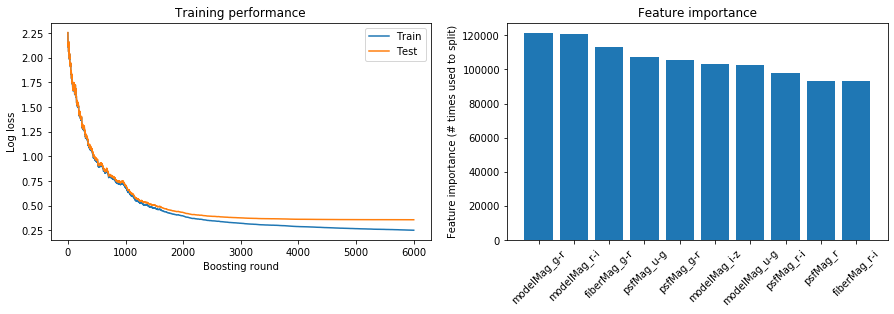

In [34]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['multi_logloss'], label='Train')
axs[0].plot(evaluation_results['Test']['multi_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': lgmb_model.feature_name(), 
                            'importance': lgmb_model.feature_importance()}).sort_values('importance', ascending=False).head(10)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')
plt.xticks(rotation=45)

plt.show()

In [35]:
train_y_pred = lgmb_model.predict(X_test)
real_y_pred = lgmb_model.predict(test_X)

In [36]:
#log_loss
log_loss(y_test,train_y_pred,labels= list(set(y_test)))

0.3587436018222986

In [37]:
feature_df = pd.DataFrame(lgmb_model.feature_importance(), index= train_X.columns,columns= ['importance']).sort_values('importance',ascending = False)
feature_df.head(10)

,importance
modelMag_g-r,121289
modelMag_r-i,120662
fiberMag_g-r,113396
psfMag_u-g,107039
psfMag_g-r,105224
modelMag_i-z,103235
modelMag_u-g,102535
psfMag_r-i,97607
psfMag_r,93210
fiberMag_r-i,93024


In [38]:
submission = pd.DataFrame(data=real_y_pred, columns=sample_submission_df.columns, index=sample_submission_df.index)
submission.to_csv(f'submission_lightbgm_tune_outlier_add_only({log_loss(y_test,train_y_pred,labels= list(set(y_test)))}).csv', index=True)

## Gridsearch_cv

In [ ]:
# from sklearn.feature_selection import SelectKBest
# model_kbest = SelectKBest()
# from sklearn.pipeline import Pipeline

In [ ]:
# #최적의 변수를 찾기 위한 KBest 함수 불러오기
# #파이프라인 구축
# pipe_lgbm = Pipeline([('lgbm',lgbm_c)])
# #파라미터 생성
# params_lgbm = {
#           "lgbm__max_depth": [15,20,25],
#          "lgbm__learning_rate": [0.001],
#          "lgbm__num_leaves": [15,20,25],
#          "lgbm__n_estimators": [200,300,400,500],
#          "lgbm__random_state": [42]}

In [ ]:
# #최적의 파라미터 탐색
# from sklearn.model_selection import GridSearchCV
# grid_search = GridSearchCV(pipe_lgbm, param_grid = params_lgbm,
# #                           cv=3, n_jobs=-1, verbose=10)

In [ ]:
# grid_search.fit(X_train, y_train)

In [ ]:
# lgbm_grid = grid_search.best_estimator_
# lgbm_grid